##SNNTorch is a torch-module fror Spiking Neural Networks

In [ ]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

/tmp/ipykernel_412234/3748532884.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [ ]:
# dataloader arguments
batch_size = 128
data_path = "/tmp/data/cifar10"

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#Downloading CIFAR-10

In [ ]:
# Define a transform
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0,), (1,)),
    ]
)

cifar_train = datasets.CIFAR10(
    data_path, train=True, download=True, transform=transform
)
cifar_test = datasets.CIFAR10(
    data_path, train=False, download=True, transform=transform
)

# Create DataLoaders
train_loader = DataLoader(
    cifar_train, batch_size=batch_size, shuffle=True, drop_last=True
)
test_loader = DataLoader(
    cifar_test, batch_size=batch_size, shuffle=True, drop_last=True
)

print(len(cifar_train), len(cifar_test))
cifar_test[0][0].shape

Files already downloaded and verified
Files already downloaded and verified
50000 10000


torch.Size([3, 32, 32])

#Define network

In [ ]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [ ]:
# #  Initialize Network
learn_beta = False
learn_threshold = False
hidden_channels = 16


net = nn.Sequential(
    nn.Conv2d(3, hidden_channels, 3, padding="same"),
    nn.BatchNorm2d(num_features=hidden_channels),
    nn.Conv2d(hidden_channels, hidden_channels, 3, padding="same"),
    nn.BatchNorm2d(num_features=hidden_channels),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,
              learn_beta=learn_beta, learn_threshold=learn_threshold),

    nn.Conv2d(hidden_channels, hidden_channels*2, 3, padding="same"),
    nn.BatchNorm2d(num_features=hidden_channels*2),
    nn.Conv2d(hidden_channels*2, hidden_channels*2, 3, padding="same"),
    nn.BatchNorm2d(num_features=hidden_channels*2),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,
              learn_beta=learn_beta, learn_threshold=learn_threshold),  # 42% 15 epochs

    nn.Conv2d(hidden_channels*2, hidden_channels*4, 3, padding="same"),
    nn.BatchNorm2d(num_features=hidden_channels*4),
    nn.Conv2d(hidden_channels*4, hidden_channels*4, 3, padding="same"),
    nn.BatchNorm2d(num_features=hidden_channels*4),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,
              learn_beta=learn_beta, learn_threshold=learn_threshold),  # 48.13%

    nn.Conv2d(hidden_channels*4, hidden_channels*8, 3, padding="same"),
    nn.BatchNorm2d(num_features=hidden_channels*8),
    nn.Conv2d(hidden_channels*8, hidden_channels*8, 3, padding="same"),
    nn.BatchNorm2d(num_features=hidden_channels*8),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,
              learn_beta=learn_beta, learn_threshold=learn_threshold),

    nn.Flatten(),
    nn.Linear(512, 10),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,
              learn_beta=learn_beta, learn_threshold=learn_threshold, output=False)
).to(device)

# test input-output

data, targets = next(iter(train_loader))
print(data.shape)
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out = net(data)

torch.Size([128, 3, 32, 32])


In [ ]:
def forward_pass(net, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    spike_data = spikegen.rate(
        data.to(device), num_steps=num_steps, gain=0.5).to(device)

    for step in range(num_steps):
        spk_out = net(spike_data[step].squeeze(0))
        spk_rec.append(spk_out)

    return torch.stack(spk_rec)

# test input-output


data, targets = next(iter(train_loader))
print(data.shape)
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out = net(data)

spk_rec = forward_pass(net, num_steps, data)

torch.Size([128, 3, 32, 32])


In [ ]:
loss_fn = SF.ce_rate_loss()

loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

acc = SF.accuracy_rate(spk_rec, targets)


def batch_accuracy(train_loader, net, num_steps):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()

        train_loader = iter(train_loader)
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec = forward_pass(net, num_steps, data)

            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

    return acc/total


test_acc = batch_accuracy(test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The loss from an untrained network is 2.304


The total accuracy on the test set is: 10.00%


#Define Schedulers

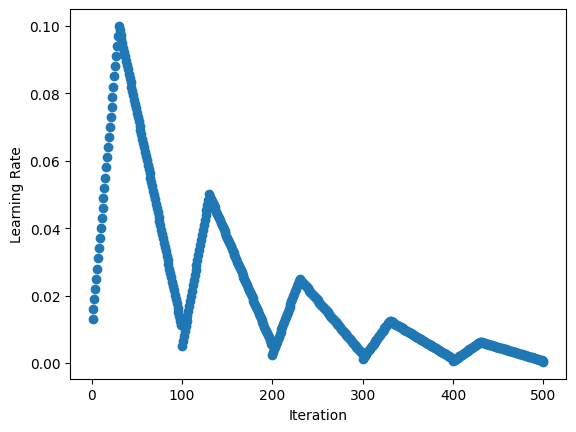

In [ ]:
%matplotlib inline
import copy
import math

import numpy as np
import matplotlib.pyplot as plt
def plot_schedule(schedule_fn, iterations=500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.show()

class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.3):
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        inc_fraction: fraction of iterations spent in increasing stage (float)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction

    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle


class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        """
        schedule_class: class of schedule, expected to take `cycle_length` argument
        cycle_length: iterations used for initial cycle (int)
        cycle_length_decay: factor multiplied to cycle_length each cycle (float)
        cycle_magnitude_decay: factor multiplied learning rate magnitudes each cycle (float)
        kwargs: passed to the schedule_class
        """
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs

    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length

        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.01, max_lr=0.1, cycle_length=100, cycle_magnitude_decay=0.5)
plot_schedule(schedule)

#Training

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
from torch.cuda.amp import GradScaler
from tqdm import trange
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 10
loss_hist = []
test_acc_hist = []
counter_global = 0
counter_local = 0


schedule = CyclicalSchedule(
    TriangularSchedule,
    min_lr=0.01,
    max_lr=0.1,
    cycle_length=3,
    cycle_magnitude_decay=0.7,
)
def lambda_schedule(iteration): return schedule(iteration)


scheduler = LambdaLR(optimizer, lr_lambda=lambda_schedule)


# Outer training loop
for epoch in range(num_epochs):
    counter_global = 0
    counter_local = 0
    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter_local // 20000 != 0:
            counter_local = counter_local % 20000
            with torch.no_grad():
                net.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(
                    f"Epoch {epoch}, Iteration {counter_global}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter_global += len(targets)
        counter_local += len(targets)
    scheduler.step()

Epoch 0, Iteration 20096, Test Acc: 27.50%

Epoch 0, Iteration 40064, Test Acc: 33.45%

Epoch 1, Iteration 20096, Test Acc: 36.22%

Epoch 1, Iteration 40064, Test Acc: 39.30%

Epoch 2, Iteration 20096, Test Acc: 41.60%

Epoch 2, Iteration 40064, Test Acc: 42.18%

Epoch 3, Iteration 20096, Test Acc: 45.16%

Epoch 3, Iteration 40064, Test Acc: 45.21%

Epoch 4, Iteration 20096, Test Acc: 45.30%

Epoch 4, Iteration 40064, Test Acc: 44.39%

Epoch 5, Iteration 20096, Test Acc: 46.38%

Epoch 5, Iteration 40064, Test Acc: 46.60%

Epoch 6, Iteration 20096, Test Acc: 48.39%

Epoch 6, Iteration 40064, Test Acc: 48.65%

Epoch 7, Iteration 20096, Test Acc: 46.69%

Epoch 7, Iteration 40064, Test Acc: 47.39%

Epoch 8, Iteration 20096, Test Acc: 49.27%

Epoch 8, Iteration 40064, Test Acc: 48.60%

Epoch 9, Iteration 20096, Test Acc: 49.99%

Epoch 9, Iteration 40064, Test Acc: 50.06%



In [ ]:
from torch.optim.lr_scheduler import LambdaLR
from torch.cuda.amp import GradScaler
from tqdm import trange
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 20
loss_hist = []
test_acc_hist = []
counter_global = 0
counter_local = 0
epoch = 10


schedule = CyclicalSchedule(
    TriangularSchedule,
    min_lr=0.01,
    max_lr=0.1,
    cycle_length=3,
    cycle_magnitude_decay=0.7,
)
def lambda_schedule(iteration): return schedule(iteration)


scheduler = LambdaLR(optimizer, lr_lambda=lambda_schedule)


# Outer training loop
for epoch in range(epoch, num_epochs):
    counter_global = 0
    counter_local = 0
    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter_local // 20000 != 0:
            counter_local = counter_local % 20000
            with torch.no_grad():
                net.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(
                    f"Epoch {epoch}, Iteration {counter_global}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter_global += len(targets)
        counter_local += len(targets)
    scheduler.step()

Epoch 10, Iteration 20096, Test Acc: 50.36%

Epoch 10, Iteration 40064, Test Acc: 50.27%

Epoch 11, Iteration 20096, Test Acc: 47.56%

Epoch 11, Iteration 40064, Test Acc: 46.57%

Epoch 12, Iteration 20096, Test Acc: 48.72%

Epoch 12, Iteration 40064, Test Acc: 49.61%

Epoch 13, Iteration 20096, Test Acc: 51.02%

Epoch 13, Iteration 40064, Test Acc: 50.95%

Epoch 14, Iteration 20096, Test Acc: 49.78%

Epoch 14, Iteration 40064, Test Acc: 48.70%

Epoch 15, Iteration 20096, Test Acc: 50.69%

Epoch 15, Iteration 40064, Test Acc: 51.38%

Epoch 16, Iteration 20096, Test Acc: 52.33%

Epoch 16, Iteration 40064, Test Acc: 52.53%

Epoch 17, Iteration 20096, Test Acc: 51.18%

Epoch 17, Iteration 40064, Test Acc: 50.85%

Epoch 18, Iteration 20096, Test Acc: 52.61%

Epoch 18, Iteration 40064, Test Acc: 53.29%

Epoch 19, Iteration 20096, Test Acc: 53.19%

Epoch 19, Iteration 40064, Test Acc: 53.60%



In [ ]:
from torch.optim.lr_scheduler import LambdaLR
from torch.cuda.amp import GradScaler
from tqdm import trange
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 60
loss_hist = []
test_acc_hist = []
counter_global = 0
counter_local = 0
epoch = 20


schedule = CyclicalSchedule(
    TriangularSchedule,
    min_lr=0.01,
    max_lr=0.1,
    cycle_length=3,
    cycle_magnitude_decay=0.7,
)
def lambda_schedule(iteration): return schedule(iteration)


scheduler = LambdaLR(optimizer, lr_lambda=lambda_schedule)


# Outer training loop
for epoch in range(epoch, num_epochs):
    counter_global = 0
    counter_local = 0
    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter_local // 20000 != 0:
            counter_local = counter_local % 20000
            with torch.no_grad():
                net.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(
                    f"Epoch {epoch}, Iteration {counter_global}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter_global += len(targets)
        counter_local += len(targets)
    scheduler.step()

Epoch 20, Iteration 20096, Test Acc: 54.01%

Epoch 20, Iteration 40064, Test Acc: 54.05%

Epoch 21, Iteration 20096, Test Acc: 50.62%

Epoch 21, Iteration 40064, Test Acc: 50.12%

Epoch 22, Iteration 20096, Test Acc: 52.26%

Epoch 22, Iteration 40064, Test Acc: 52.78%

Epoch 23, Iteration 20096, Test Acc: 53.54%

Epoch 23, Iteration 40064, Test Acc: 53.98%

Epoch 24, Iteration 20096, Test Acc: 51.27%

Epoch 24, Iteration 40064, Test Acc: 52.70%

Epoch 25, Iteration 20096, Test Acc: 53.36%

Epoch 25, Iteration 40064, Test Acc: 53.66%

Epoch 26, Iteration 20096, Test Acc: 54.50%

Epoch 26, Iteration 40064, Test Acc: 54.57%

Epoch 27, Iteration 20096, Test Acc: 53.91%

Epoch 27, Iteration 40064, Test Acc: 53.06%

Epoch 28, Iteration 20096, Test Acc: 54.72%

Epoch 28, Iteration 40064, Test Acc: 53.48%

Epoch 29, Iteration 20096, Test Acc: 54.96%

Epoch 29, Iteration 40064, Test Acc: 54.77%

Epoch 30, Iteration 20096, Test Acc: 54.47%

Epoch 30, Iteration 40064, Test Acc: 54.42%

Epoch 31, 

#Results

In [ ]:
test_acc = batch_accuracy(test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 57.26%


In [ ]:
import torch
import time
import gc

COLAB = True

DEVICE = "cuda"


def cache_clear():  # In colab to clear GPU cache you need to wait some time after deleting tensor
    if COLAB:
        time.sleep(0.08)
    torch.cuda.empty_cache()


def gpu_util():  # To monitor how much more can we load GPU with data
    if DEVICE == "cuda":
        return (
            torch.cuda.memory_allocated(DEVICE)
            / torch.cuda.get_device_properties(DEVICE).total_memory
        )
    if DEVICE == "cpu":
        return 0


cache_clear()
print(torch.cuda.memory_reserved(DEVICE))
print(torch.cuda.get_device_properties(DEVICE))

gc.collect()
gpu_util()

7952400384
_CudaDeviceProperties(name='NVIDIA L4', major=8, minor=9, total_memory=22699MB, multi_processor_count=58)


0.3319636861298796